# Calculate EOFs using the PCA module

In [1]:
# import modules
import pandas as pd
from sklearn.decomposition import PCA
import xarray as xr
import numpy as np
import pylab as plt
import re
import GPy as gp
import pylab as plt
import matplotlib.colors as colors

from pismemulator.utils import prepare_data

In [2]:
# Setup PCA

total_variance = 0.995
# Set up PCA such that enough components are calculated to explain at least the "total_variance"
pca = PCA(n_components=total_variance)
log_pca = PCA(n_components=total_variance)

First we load the observed speeds

In [5]:
o_file = "../data/speeds/greenland_vel_mosaic250_v1_g1800m.nc"
o_xr = xr.open_dataset(o_file)

o_speed = o_xr.variables["velsurf_mag"].values
o_speed_sigma = o_xr.variables["velsurf_mag_error"].values

o_ny, o_nx = o_speed.shape
o_xr.close()

o_speeds = np.nan_to_num(o_speed, 0).reshape(-1, 1)
o_speeds_sigma = np.nan_to_num(o_speed_sigma, 0).reshape(-1, 1)

Second we load the raw files and create anomalies ourselves. Be careful to honor nans and removed them afterwards to get the same result as CDO.

In [6]:
from glob import glob
s_files = glob("../data/speeds/velsurf_mag_gris_g1800m_v3a_id_*_0_50.nc")
nt = len(s_files)

# open first file to get the dimensions
vxr0 = xr.open_dataset(s_files[0])
speed = vxr0.variables["velsurf_mag"].values
_, ny, nx = speed.shape
vxr0.close()

m_speeds = np.zeros((nt, ny * nx))

# Go through all files and don't forget to extract the experiment id
ids = []
for k, s_file in enumerate(s_files):
    vxr = xr.open_dataset(s_file)
    ids.append(re.search("id_(.+?)_0", s_file).group(1))
    m_speeds[k, ::] = vxr.variables["velsurf_mag"].values.flatten()
    vxr.close()

# For comparison, we run the analysis for both u and log10(u)
m_speeds_mean = np.nanmean(m_speeds, axis=0)
m_speeds_anom = m_speeds - m_speeds_mean
m_speeds_anom = np.nan_to_num(m_speeds_anom, 0)

m_log_speeds = np.log10(np.nan_to_num(m_speeds, 0))
m_log_speeds[np.isneginf(m_log_speeds)] = 0
m_log_speeds_mean = np.nanmean(m_log_speeds, axis=0)
m_log_speeds_anom =  m_log_speeds - m_log_speeds_mean
m_log_speeds_anom[np.isneginf(m_log_speeds_anom)] = 0
m_log_speeds_anom = np.nan_to_num(m_log_speeds_anom, 0)

 <ipython-input-6-8f5418094829>:22: RuntimeWarning:Mean of empty slice
 <ipython-input-6-8f5418094829>:26: RuntimeWarning:divide by zero encountered in log10


Now run the PCA (fit to speeds)

In [7]:
m_pca = pca.fit(m_speeds_anom)
m_log_pca = log_pca.fit(m_log_speeds_anom)

In [9]:
# The log10(U) require a lot more eigenvalues to explain the same variance, why?
print(m_pca.n_components_)
print(m_log_pca.n_components_)

36
83


## Eigenvalues

In the parlange of the PCA module,

`explained_variance_` are the `eigenvectors`
and
`components_` are the `eigenvalues` $e_j(t)$.

In [10]:
# The eigenvalues of the log10(U) are much smaller than U
m_eigenvalues = m_pca.explained_variance_
m_log_eigenvalues = m_log_pca.explained_variance_

## Eigenvectors

In [11]:
m_eigenvectors = m_pca.components_
m_log_eigenvectors = m_log_pca.components_

## Coefficients

Calculate the coefficients $o_j(t)$, which are the dot product of the eigen vectors with the anomaly matrix according to
\begin{equation}
o_j(t) = \sum_{x=i}^p z(t,x) e_j(x)
\end{equation}

In [12]:
m_coefficients = np.dot(m_eigenvectors, m_speeds_anom.T)
m_log_coefficients = np.dot(m_log_eigenvectors, m_log_speeds_anom.T)

Put coefficients in DataFrame and save to CSV.

In [13]:
response_file = "m_speed_coefficients.csv"
df = pd.DataFrame(data=m_coefficients.T[:,:], index=ids)
print(df.head())
df.to_csv(response_file, index_label="id")

log_response_file = "m_log_speed_coefficients.csv"
df = pd.DataFrame(data=m_log_coefficients.T[:,:], index=ids)
print(df.head())
df.to_csv(log_response_file, index_label="id")

               0              1             2             3              4   \
53 -102309.267848   17016.298350  29885.065907   6242.046923    4488.959954   
43 -212965.461731   12024.965459  33512.427869  23248.218526   18574.757479   
31  295078.055828  128579.763740  92527.099710 -14141.841948  -25149.728647   
21 -217399.802197    7511.953584  31703.380992  23770.899131   17448.731095   
88  210574.776376 -104925.112992 -68636.908746 -58700.725560 -104667.521129   

              5              6              7              8             9   \
53  28031.015331    3912.698644  -10313.362388   16938.352609 -12797.909442   
43   2197.899269  -12387.586189    9642.302263  -12964.039545  10249.376120   
31  94881.099651  142561.738528 -140395.431379  164638.972122   2062.564555   
21  -3252.961369  -13371.927262   12568.608198  -14804.643077  10794.766219   
88 -94154.158523   54851.050077  -64332.269308  -27614.682822  47905.879903   

    ...            26            27            28 

Eigenglaciers

The first $n$ Eigenglaciers of ensemble member id=36 are:

Reconstruction
Reconstruction with log-speeds


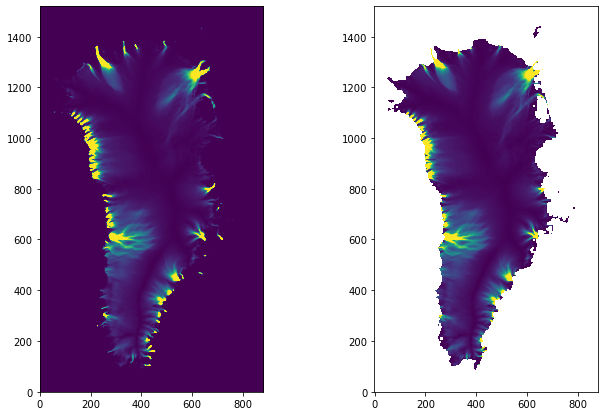

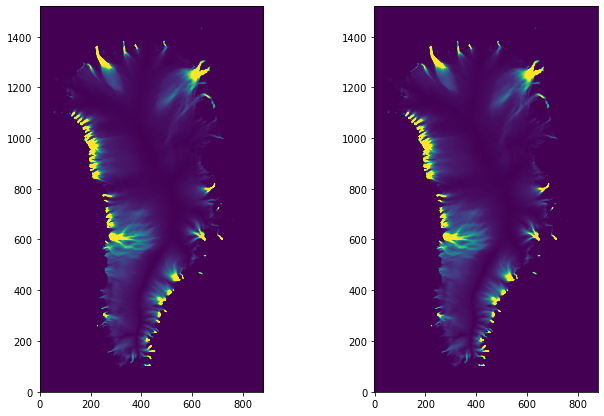

In [14]:
id = 36

n = m_pca.n_components_
n_log = m_log_pca.n_components_

reconstructed_speeds = m_speeds_mean.reshape(ny, nx)
for i in range(0, n):
    eigenglacier = (m_coefficients[i][id] * m_eigenvectors[i]).reshape(ny, nx)
    reconstructed_speeds += eigenglacier

print("Reconstruction")
fig, ax = plt.subplots(1, 2, sharex="col", figsize=[10, 120])
fig.subplots_adjust(hspace=0.05, wspace=0.5)
ax[0].imshow(m_speeds[id].reshape(ny, nx), origin="lower", cmap="viridis", vmin=0, vmax=500)
ax[1].imshow(reconstructed_speeds, origin="lower", cmap="viridis", vmin=0, vmax=500)
# plt.colorbar(c)

# Same, but for log-speeds
reconstructed_speeds = m_log_speeds_mean.reshape(ny, nx)
for i in range(0, n_log):
    eigenglacier = (m_log_coefficients[i][id] * m_log_eigenvectors[i]).reshape(ny, nx)
    reconstructed_speeds += eigenglacier

print("Reconstruction with log-speeds")
fig, ax = plt.subplots(1, 2, sharex="col", figsize=[10, 120])
fig.subplots_adjust(hspace=0.05, wspace=0.5)
ax[0].imshow(m_speeds[id].reshape(ny, nx), origin="lower", cmap="viridis", vmin=0, vmax=500)
ax[1].imshow(10 ** reconstructed_speeds, origin="lower", cmap="viridis", vmin=0, vmax=500)


In [15]:
# Just some sanity check, making sure we understand the PCA module
lower_dimensional_data = m_pca.fit_transform(m_speeds)
approximation = m_pca.inverse_transform(lower_dimensional_data)
# Add mean back to approximation
pca_reconstruction = approximation[id].reshape(ny, nx)
pca_reconstructed_speeds = pca_reconstruction + m_speeds_mean.reshape(ny, nx)

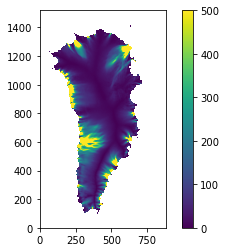

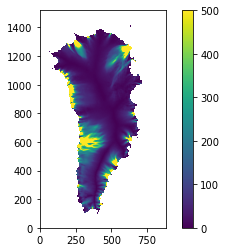

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
c = ax.imshow(m_speeds[id].reshape(ny, nx) + m_speeds_mean.reshape(ny, nx), origin="lower", cmap="viridis", vmin=0, vmax=500)
plt.colorbar(c)

fig = plt.figure()
ax = fig.add_subplot(111)
c = ax.imshow(pca_reconstructed_speeds, origin="lower", cmap="viridis", vmin=0, vmax=500)
plt.colorbar(c)

Read the samples and their responses (coefficients) for the log-speeds.

In [18]:
samples_file = "../data/samples/velocity_calibration_samples_10.csv"
samples, response = prepare_data(samples_file, log_response_file)



Preparing sample ../data/samples/velocity_calibration_samples_10.csv and response m_log_speed_coefficients.csv


In [19]:
X = samples.values
Y = response.values
n_dim = X.shape[1]

Read in the new samples that we want to emulate (an ensemble much larger than used for the high-fidelity model)

In [21]:
df = pd.read_csv("../data/samples/velocity_calibration_samples_100.csv", delimiter=",", squeeze=True, skipinitialspace=True)
X_new = df.values[:, 1::]

Now construct surrogate models for different covariance functions (kernels). Here we do this for the log-speeds because the optimized models have much smaller variances compared to the non-log speeds.

In [23]:
# Make a GP regression model

# Dictionary of GP kernels
gp_methods = {
    "rbf": gp.kern.RBF,
    "exp": gp.kern.Exponential,
    "expquad": gp.kern.ExpQuad,
    "mat32": gp.kern.Matern32,
    "mat52": gp.kern.Matern52,
}

models = {}
for key, kern in gp_methods.items():
    kernel = kern(input_dim=n_dim, ARD=True)
    m = gp.models.GPRegression(X, Y, kernel)
    f = m.optimize(messages=True)

    models[key] = m

In [ ]:
# Reconstruct emulated glaciers
# This is currently very slow

m = models["exp"]
p = m.predict(X_new)
m_log_coefficients_em = p[0]
ng = len(df)
m_log_speeds_em = np.zeros((ng, ny, nx))
print(m_log_coefficients.shape, m_log_eigenvectors.shape, ng, n_log)
for id in range(0, ng):
   print(f"Processing sample glacier {id}")
   reconstructed_speeds = m_log_speeds_mean.reshape(ny, nx)
   for i in range(0, n_log):
       eigenglacier = (m_log_coefficients_em[id][i] * m_log_eigenvectors[i]).reshape(ny, nx)
       reconstructed_speeds += eigenglacier
   m_log_speeds_em[id, :, :] = reconstructed_speeds
m_speeds_em = 10 ** m_log_speeds_em

Generate a GP model with an exponential kernel (Eq 54)

In [ ]:
kernel = gp_methods["exp"](input_dim=n_dim, ARD=True)

What is the residual function $r(x)$ in Eq. 55

In [ ]:
# np.linalg.norm(m_log_speeds, axis=0) is not G(x,m,w)
# Do I do this with log(U) or U?

R = np.array(np.linalg.norm(m_speeds_em.reshape(ng, -1), axis=1) - np.linalg.norm(o_speeds)).reshape(-1, 1)
# Here we need to add the noise variance which is the observational variance via noise_var=...
m = gp.models.GPRegression(X_new, R, kernel, noise_var=np.var(o_speeds_sigma))

In [ ]:
# For fun, run MCMC over the high-fidelity model
hmc = gp.inference.mcmc.HMC(m, stepsize=5e-2)
s = hmc.sample(num_samples=1000) # Burnin
s = hmc.sample(num_samples=2000)